In [1]:
# coding: utf-8

# In[1]:



# In[ ]:

import underworld as uw
import math
from underworld import function as fn
import numpy as np
import os
from unsupported.lithopress import lithoPressure
from unsupported.LMR import *
import unsupported.scaling as sca
from unsupported.scaling import nonDimensionalize as nd

# In[ ]:

inputPath = os.path.join(os.path.abspath("."),"Compression/")
outputPath = os.path.join(os.path.abspath("."),"Compression/")
if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
if uw.rank()==0:
    if not os.path.exists(inputPath):
        os.makedirs(inputPath)
uw.barrier()
# continue running from specific time step
LoadFromFile=False


u = sca.UnitRegistry

# Define scale criteria
tempMin = 273.*u.degK 
tempMax = (1400.+ 273.)*u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
velocity = 1.*u.centimeter/u.year

KL = 150e3*u.meter
Kt = KL/velocity
KT = tempMax 
KM = bodyforce * KL**2 * Kt**2
K  = 1.*u.mole
lengthScale = 150e3

sca.scaling["[length]"] = KL
sca.scaling["[time]"] = Kt
sca.scaling["[mass]"]= KM
sca.scaling["[temperature]"] = KT
sca.scaling["[substance]"] = K

gravity = nd(9.81 * u.meter / u.second**2)
R = nd(8.3144621 * u.joule / u.mole / u.degK)

# use low resolution if running in serial
xRes = 128
yRes = 64
dim  = 2


maxX = nd( 200. * u.kilometer)
minX = nd( -200. * u.kilometer)
boxWidth = nd( 300. * u.kilometer)
stickyAirthick = nd(10. * u.kilometer)

ucThick = nd(20. *u.kilometer)
lcThick = nd(20. *u.kilometer)
meshV = nd(-1.*u.centimeter/u.year)
lithMantle = 3*lcThick

stickyAirIndex        = 0
crustUpIndex          = 1
crustLowIndex         = 2
mantleIndex           = 3
asthenIndex           = 4

if(LoadFromFile == True):
    step =380
    fo = open(inputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time = float(t)
else:
    step = 0
    time = 0.  # Initial time
maxSteps = 1500   # Maximum timesteps (301 is recommended)
steps_output = 2 # output every 1 timesteps, increase for high resolution


# In[ ]:

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (minX, 0.), 
                                 maxCoord    = (maxX, boxWidth),
                                 periodic    = [False, False]) 
velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureFieldCopy    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

temperatureDotField.data[:] = nd(273.*u.degK)
temperatureField.data[:] = nd(273.*u.degK)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.



# In[2]:

# In[ ]:

if(LoadFromFile == True):
    # Setup mesh and temperature field for 64*64 data file.
    temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 ) 
    velocityField   = uw.mesh.MeshVariable( mesh=mesh,  nodeDofCount=dim ) 
    pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
    # read in saved steady state temperature field data

    temperatureField.load(inputPath+"temperatureField"+str(step).zfill(4)) 
    velocityField.load(inputPath+"velocityField"+str(step).zfill(4))
    pressureField.load(inputPath+"pressureField"+str(step).zfill(4))    


# In[ ]:

# set initial conditions (and boundary values)

tempMin = nd(273. *u.degK)
tempMax = nd(1673. *u.degK)
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin
    
# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
left   = mesh.specialSets["MinI_VertexSet"]

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [-meshV, 0.]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [meshV, 0.]
    
freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, base) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )


# In[ ]:

if(LoadFromFile == False):
    # define temperature field according to cooling lithosphere model
    dtdy = nd(0.3* u.degK / u.kilometer) # adabatic gradient 0.3 K/km
    kappa = nd(1.e-6* u.meter*u.meter/u.second) # thermal diffusivty m^2/s
    #age = 20.0*1.e6*365.0*24.0*3600.0 #plate age 80 Ma

    #depthLab = 100.e3
    tempPotential = nd(1573.* u.degK)
    #tempLab = tempPotential+((tempMin -tempPotential)*(1-math.erf((depthLab)/(2.0*math.pow(kappa*age,0.5)))))
    coordTop = boxWidth - stickyAirthick
    #coordLab = boxHeight - depthLab - stickyAirthick
    def age(x,y):
        val=45
        val_s = val*1.e6 
        return nd(val_s*u.year)
       # return (25+2.857e-6*x+5.5e-5*y-1.143e-11*x*y-5e-11*y*y)*1.e6*365.0*24.0*3600.0 
    for index, coord in enumerate(mesh.data):
        x=coord[0]
        y=coord[1]

        if coord[1]<=coordTop:
            conductionTherm=tempPotential+((tempMin -tempPotential)*(1.-math.erf((coordTop-coord[1])/(2.0*math.pow(kappa*age(x,y),0.5)))))  
            adTherm=tempPotential+dtdy*(coordTop-coord[1])
            temperatureField.data[index]= min(adTherm,conductionTherm)
        


# In[ ]:

swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True )
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,particlesPerCell=25)
surfaceSwarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True  )

materialVariable   = swarm.add_variable( dataType="int", count=1 )
plasticStrain  = swarm.add_variable( dataType="double",  count=1 )
frictionInf  = swarm.add_variable( dataType="double",  count=1 )
cohesion  = swarm.add_variable( dataType="double",  count=1 )

stretching = swarm.add_variable( dataType="double", count=dim)
orientation = swarm.add_variable( dataType="double", count=1)

if(LoadFromFile == False): 
    swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell= 25 )
    swarm.populate_using_layout( layout=swarmLayout )

    countx=26*20
    county=21*20
    xcoord = np.linspace(minX, maxX, countx)
    ycoord = np.linspace(0.0, boxWidth, county)
    surfacePoints = np.zeros( (countx,2))

    for j in range(countx):        
        n = j
        surfacePoints[n,0] = xcoord[j] 
        surfacePoints[n,1] = boxWidth-stickyAirthick-nd(6.*u.kilometer)
        
    surfaceSwarm.add_particles_with_coordinates( surfacePoints )

    # Stretching - assume an initial orientation aligned with the x-axis

    stretching.data[:,0] = 0.0
    stretching.data[:,1] = 1.0
    # This is a work-variable for visualisation

    orientation.data[:] = 0.0
    plasticStrain.data[:] = 0  

# In[ ]:



# In[ ]:

if(LoadFromFile == True):    
    surfaceSwarm.load(inputPath+"surfaceSwarm"+str(step).zfill(4))
    swarm.load(inputPath+"swarm"+str(step).zfill(4))
    materialVariable.load(inputPath+"materialVariable"+str(step).zfill(4))   
    plasticStrain.load(inputPath+"plasticStrain"+str(step).zfill(4))


# In[ ]:

if(LoadFromFile == False):
    # initialise the 'materialVariable' data to represent foure different materials. 


    materialVariable.data[:] = mantleIndex 
        
    # change matieral index if the particle is not lithosphere mantle
    for index, coord in enumerate(swarm.particleCoordinates.data):
        x = coord[0]
        z = coord[1]
        if (z>boxWidth-stickyAirthick):
            materialVariable.data[index] = stickyAirIndex
        if (z<boxWidth-stickyAirthick and z > boxWidth-stickyAirthick-ucThick-lcThick ):
            materialVariable.data[index] = crustUpIndex    
            if (x< 0. and z < boxWidth-stickyAirthick-ucThick):
                materialVariable.data[index] = crustLowIndex
        if (z<=boxWidth-stickyAirthick-ucThick-lcThick-lithMantle):
            materialVariable.data[index] = asthenIndex
   

/home/haibin/underworld/unsupported/lithopress/__init__.py:8: UserWarning: 

The lithopress module is not supported.

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/home/haibin/underworld/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


<module 'glucifer.lavavu' from '/home/haibin/underworld/glucifer/lavavu.pyc'>


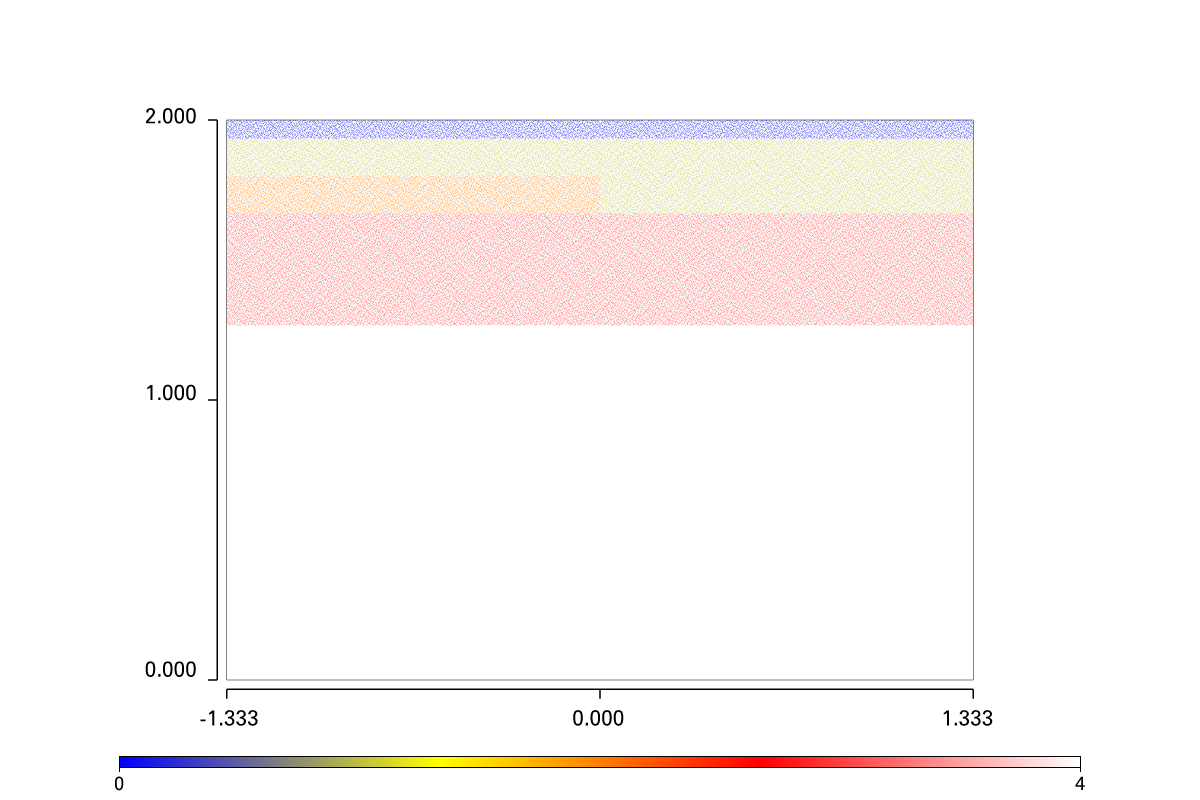

2.0


In [2]:
import glucifer
figTemperature= glucifer.Figure( figsize=(1200,800),quality=3, margin=120, rulers=True, rulerticks=3 )
figTemperature.append( glucifer.objects.Points(swarm,materialVariable, colours="blue yellow red white") )
figTemperature.show()
if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
lv = figTemperature.viewer()
lv.rotate('z', 90)
lv.rotate('x', -45)
lv.redisplay()
print max(mesh.data[:,1])

In [3]:
# In[3]:

# In[ ]:
print "finish material fil"
   


# In[ ]:

# Friction - in this form it could also be made to weaken with strain
C0 = nd(5.0e7* u.pascal)
F0 = 0.6
C1 = nd(5.0e7* u.pascal)
F1 = 0.6
strainLow = 0.5
strainUp = 1.5
cohesion.data[:]  = C0
frictionInf.data[:]  = F0 
# Drucker-Prager yield criterion
for index, coord in enumerate(swarm.particleCoordinates.data):
    
    if plasticStrain.data[index]>strainLow  and plasticStrain.data[index]<=strainUp:
        cohesion.data[index] = C0+(C1-C0)/(strainUp-strainLow)*(plasticStrain.data[index]-strainLow)
        frictionInf.data[index]  = F0+(F1-F0)/(strainUp-strainLow)*(plasticStrain.data[index]-strainLow)
        
    if plasticStrain.data[index] >strainUp:
        cohesion.data[index]  = C1
        frictionInf.data[index]  = F1
 
        
yieldStressFn   = cohesion  + frictionInf * pressureField



# min_viscosity = 1.e18
# viscosityMap = {        stickyAirIndex  : 1.0e18, 
#                         crustIndex      : 1.0e22, 
#                         lithMantleIndex : 5.0e22,
#                         asthenIndex     : 1.0e21}
# backgroundViscosityFn  = fn.branching.map( fn_key = materialVariable, 
#                                            mapping = viscosityMap )
# viscosityMapFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
#                                                               backgroundViscosityFn), 
#                                                   min_viscosity))

# In[ ]:

stickyAirViscosity           = nd(1e19 * u.pascal * u.second)
min_viscosity                = stickyAirViscosity 
max_viscosity                = nd(1e24 * u.pascal * u.second)
upcrustViscosity_Factor      = nd(0.00032 / u.megapascal ** 2.3 / u.second)
upcrustViscosity_n           = 2.3
upcrustViscosity_Q           = nd(154.*u.kilojoule / u.mole)
upcrustViscosity_V           = 0.
lowcrustViscosity_Factor     = nd(3.3283*1e-4/ u.megapascal ** 3.2 / u.second)
lowcrustViscosity_n          = 3.2
lowcrustViscosity_Q          = nd(240.*u.kilojoule / u.mole)
lowcrustViscosity_V          = 0.
lithMantleViscosity_Factor   = nd(math.pow (10.,6.1)/ u.megapascal ** 3. / u.second)
lithMantleViscosity_n        = 3.
lithMantleViscosity_Q        = nd(510.*u.kilojoule / u.mole)
lithMantleViscosity_V        = nd(14.*u.centimeter**3/u.mol)
gasconstant                  = R # unit: kg m2 s−2 K−1 mol−1

# The yeilding of the lithosphere is dependent on the strain rate.
# first define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRateFn)+nd(1e-18/u.second)

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariant)

print max(temperatureField.data)
def materialStress(factor,n,Q,V,strainrate,pressure,temperature): 
    return fn.math.pow(factor,-1./n)*fn.math.pow(strainrate,(1./n))*fn.math.exp((Q+pressure*V)/(n*gasconstant*temperature))



upcrustViscosity = materialStress(upcrustViscosity_Factor,upcrustViscosity_n,\
                upcrustViscosity_Q,upcrustViscosity_V,strainRate_2ndInvariant,pressureField,temperatureField)\
                /(2.*(strainRate_2ndInvariant))
lowcrustViscosity = materialStress(lowcrustViscosity_Factor,lowcrustViscosity_n,\
                lowcrustViscosity_Q,lowcrustViscosity_V,strainRate_2ndInvariant,pressureField,temperatureField)\
                /(2.*(strainRate_2ndInvariant))
mantleViscosity = materialStress(lithMantleViscosity_Factor,lithMantleViscosity_n,
                lithMantleViscosity_Q,lithMantleViscosity_V,strainRate_2ndInvariant,pressureField,temperatureField)\
                /(2.*(strainRate_2ndInvariant))
#asthenViscosity = math.pow(10,-6/lithMantleViscosity_n)*materialViscosity(100*lithMantleViscosity_Factor,lithMantleViscosity_n,
#                                   1000*lithMantleViscosity_Q,lithMantleViscosity_V,strainRate_2ndInvariant,
#                                  pressure,temperature)
# The lithosphere viscosity is the minimum of the 'crustViscosity/lithMantle' or the 'vonMises' 
# Viscosity function for the materials 
viscosityMap = {        stickyAirIndex  : stickyAirViscosity, 
                        crustUpIndex    : upcrustViscosity,
                        crustLowIndex   : lowcrustViscosity,
                        mantleIndex     : mantleViscosity,
                        asthenIndex     : mantleViscosity}
backgroundViscosityFn  = fn.branching.map( fn_key = materialVariable, 
                                           mapping = viscosityMap )
viscosityMapFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min( backgroundViscosityFn,max_viscosity), 
                                                  min_viscosity))


# In[ ]:

devStressFn = 2.0 * viscosityMapFn*strainRateFn


# In[ ]:

densityMap0 = { stickyAirIndex    : nd(   1000. * u.kilogram / u.metre**3), 
                 crustUpIndex     : nd(   2700. * u.kilogram / u.metre**3),
                 crustLowIndex    : nd(   2900. * u.kilogram / u.metre**3),
                 mantleIndex      : nd(   3200. * u.kilogram / u.metre**3),
                 asthenIndex      : nd(   3200. * u.kilogram / u.metre**3)}
densityFn0 = fn.branching.map( fn_key = materialVariable, mapping = densityMap0 )
thermalExpansion = nd(1e-5 / u.kelvin)
compressibility = nd(1e-11 / u.pascal)
densityFn = densityFn0#*(1.-thermalExpansion*(temperatureField-273.))*(1.+compressibility*(pressureField-1e5))
# Define our vertical unit vector using a python tuple
z_hat = ( 0.0, -1.0 )

# now create a buoyancy force vector
buoyancyFn = densityFn * z_hat * gravity


# In[ ]:

# radioactive heat generation , Unit: w/m3
sourceMapRad = { stickyAirIndex       : 0.0, 
                 crustUpIndex         : nd(4.0e-7* u.watt/u.meter**3), 
                 crustLowIndex        : nd(1.0e-7* u.watt/u.meter**3), 
                 mantleIndex          : nd(1.0e-8* u.watt/u.meter**3),
                 asthenIndex          : nd(1.0e-9* u.watt/u.meter**3)}
thermalCompacity = nd(1200. * u.joule / (u.kelvin * u.kilogram))
sourceRad = fn.branching.map( fn_key = materialVariable, mapping = sourceMapRad )
sourceRadFn = sourceRad/(densityFn*thermalCompacity)

def conductivity(k0,alpa, temperature):
    return k0+alpa/(temperature+nd(77.*u.degK))

stickyAirConductivity=conductivity(nd(100.*u.watt/(u.meter*u.degK)),0.,temperatureField)
crustConductivity = conductivity(nd(0.64*u.watt/(u.meter*u.degK)), nd(807.*u.degK),temperatureField)
mantleConductivity = conductivity(nd(0.73*u.watt/(u.meter*u.degK)), nd(1293.*u.degK),temperatureField)
asthenConductivity = conductivity(nd(0.73*u.watt/(u.meter*u.degK)), nd(1293.*u.degK),temperatureField)

conductivityMap = {     stickyAirIndex       : stickyAirConductivity, 
                        crustUpIndex         : crustConductivity , 
                        crustLowIndex        : crustConductivity ,
                        mantleIndex          : mantleConductivity,
                        asthenIndex          : mantleConductivity}
conductivityFn  = fn.branching.map( fn_key = materialVariable, 
                                           mapping = conductivityMap )
diffusionFn= conductivityFn/(densityFn*thermalCompacity)

'''
def sourceShearFn(devStressFn,strainRateFn):
    return (devStressFn[0] * strainRateFn[0] + devStressFn[1] * strainRateFn[1] +            devStressFn[2] * strainRateFn[2] + 2.0*(devStressFn[3]*strainRateFn[3]+           devStressFn[4] * strainRateFn[4] + devStressFn[5]*strainRateFn[5]))
'''
#sourceShear = sourceShearFn(devStressFn,strainRateFn) /(densityFn*thermalCompacity) 
sourceRad = fn.branching.map( fn_key = materialVariable, mapping = sourceMapRad )
sourceFn = sourceRadFn #sourceShear 


# In[5]:

# In[ ]:

surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
def nonLinearSolver(step, nl_tol=1e-2, nl_maxIts=20):
    # a hand written non linear loop for stokes, with pressure correction
    
    er = 1.0
    its = 0                      # iteration count
    v_old = velocityField.copy() # old velocityField 

    while er > nl_tol and its < nl_maxIts:

        v_old.data[:] = velocityField.data[:]
        solver.solve(nonLinearIterate=False)

        # pressure correction for bob (the feed back pressure)

       # minP.evaluate(mesh.subMesh)
        (area,) = surfaceArea.evaluate()
        (p0,) = surfacePressureIntegral.evaluate() 
        pressureField.data[:] -= (p0 / area)
        
        # update lithostatic pressure
        #projectorDensity.solve()
        #lithoPressureField.data[:] = lithoPressure(mesh, lithoPressureField, DensityVar, gravity)

        # calculate relative error
        absErr = uw.utils._nps_2norm(velocityField.data-v_old.data)
        magT   = uw.utils._nps_2norm(v_old.data)
        er = absErr/magT
            
        its += 1


# In[ ]:

# Initial linear slab viscosity setup
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosityMapFn, 
                               fn_bodyforce   = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)


# In[ ]:

# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    solver.set_inner_method("lu")
else:
    solver.set_inner_method("mumps")
#solver.set_penalty(1.0e-5)

# In[ ]:

advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField,
                                         velocityField, fn_diffusivity=diffusionFn,
                                         fn_sourceTerm= sourceFn,
                                         conditions=[tempBC,] )
advector1  = uw.systems.SwarmAdvector( swarm=swarm,     velocityField=velocityField, order=2 )
#advector  = uw.systems.SwarmAdvector( swarm=surfaceSwarm,     velocityField=velocityField, order=2 )
advector2  = uw.systems.SwarmAdvector( swarm=surfaceSwarm,     velocityField=velocityField, order=2 )


# In[ ]:

#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )


# In[ ]:
mesh_vels = meshV*np.copy(mesh.data[:,0])/maxX

finish material fil
[ 0.9402271]


In [4]:
print max(mesh.data[:,1])

2.0


In [5]:
def update():
    # get timestep and advect particles
    dt1 = advDiff.get_max_dt()
    dt2 = advector1.get_max_dt()

    
    i = 1
    stepDif = dt1
    while (stepDif+dt1)< dt2:
        dt_T = advDiff.get_max_dt()
        advDiff.integrate(dt_T)
        
        i = i+1
        stepDif = stepDif+dt1
        
    dt = stepDif
    print 'advDiff=',dt1
    print 'advector=',dt2
    print 'stepDif=',dt
    
    #advDiff.integrate(dt)
    advector1.integrate(dt)
    advector2.integrate(dt)
    
    with mesh.deform_mesh( isRegular=True ):
        mesh.data[:,0] += mesh_vels[:]*dt

    newtime = time + dt
    # recalc mesh exten
    newminX = minX - meshV * newtime
    newmaxX = maxX + meshV * newtime
    pop_control.repopulate()
    '''
    # update stretching metric
    swarmVgrad = velocityField.fn_gradient.evaluate(swarm)
    stretching.data[:,0] += dt * (swarmVgrad[:,0] * stretching.data[:,0] + swarmVgrad[:,1] * stretching.data[:,1] + swarmVgrad[:,2] * stretching.data[:,2])
    stretching.data[:,1] += dt * (swarmVgrad[:,3] * stretching.data[:,0] + swarmVgrad[:,4] * stretching.data[:,1] + swarmVgrad[:,5] * stretching.data[:,2])
    stretching.data[:,2] += dt * (swarmVgrad[:,6] * stretching.data[:,0] + swarmVgrad[:,7] * stretching.data[:,1] + swarmVgrad[:,8] * stretching.data[:,2])
    '''
    # plastic strain update
    swarmYield = viscosityMapFn.evaluate(swarm) < backgroundViscosityFn.evaluate(swarm)
    swarmStrainRateInv = strainRate_2ndInvariant.evaluate(swarm)    
    plasticStrainIncrement = dt * np.where( swarmYield , swarmStrainRateInv , 0.0 )
    plasticStrain.data[:] += plasticStrainIncrement
    

    
   
    
    return time+dt, step+1


# In[ ]:

while step <= maxSteps:
    # Solve non linear Stokes system
    nonLinearSolver(step, nl_tol=1e-3, nl_maxIts=15)
    print 'Ymin=',min(yieldingViscosityFn.evaluate(swarm))
    #solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step


        # The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
        # within an element can be significant. Mapping to the mesh can help for visualisation purposes
        meshViscosity = uw.mesh.MeshVariable( mesh, 1 )
        meshDevStress = uw.mesh.MeshVariable( mesh, 1 )

        stress2Data = fn.tensor.second_invariant(devStressFn)
        #print stress2Data.evaluate(mesh)
        projectorViscosity = uw.utils.MeshVariable_Projection( meshViscosity,viscosityMapFn, type=0 )
        projectorViscosity.solve()

        projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, stress2Data, type=0 )
        projectorStress.solve()
        
        
        meshViscosity.save(outputPath+"meshViscosity"+str(step).zfill(4)) 
        meshDevStress.save(outputPath+"meshStress"+str(step).zfill(4)) 
        
        
        swarm.save(outputPath+"swarm"+str(step).zfill(4))
        mesh.save(outputPath+"mesh"+str(step).zfill(4))
        materialVariable.save(outputPath+"materialVariable"+str(step).zfill(4))
        velocityField.save(outputPath+"velocityField"+str(step).zfill(4))
        temperatureField.save(outputPath+"temperatureField"+str(step).zfill(4))
        temperatureFieldCopy.load(outputPath+"temperatureField"+str(step).zfill(4))
        pressureField.save(outputPath+"pressureField"+str(step).zfill(4))
        surfaceSwarm.save(outputPath+"surfaceSwarm"+str(step).zfill(4))
        plasticStrain.save(outputPath+"plasticStrain"+str(step).zfill(4))
        stretching.save(outputPath+"streching"+str(step).zfill(4))
        orientation.save(outputPath+"orientation"+str(step).zfill(4))
        
        fo = open(outputPath+"time"+str(step).zfill(4),"w")
        print >> fo, time
        fo.close()
        
        dicMesh = { 'elements' : mesh.elementRes, 
                    'minCoord' : mesh.minCoord,
                    'maxCoord' : mesh.maxCoord}

        fo = open(outputPath+"dicMesh"+str(step).zfill(4),'w')
        fo.write(str(dicMesh))
        fo.close()        
  
    Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    print 'step = {0:6d}; time = {1:.3e} Myr; Vrms = {2:.3e}'.format(step,time/(1e6*365*24*3600),Vrms)

    time, step = update()

Ymin= [-0.3399787]
step =      0; time = 0.000e+00 Myr; Vrms = 2.669e+01
advDiff= 0.000107513333875
advector= 0.000212439416839
stepDif= 0.000107513333875


KeyboardInterrupt: 